# Projet 6 - Etude de faisabilité de la classification à partir des descriptions en utilisant des méthodes NLP avancées

In [1]:
#imports divers

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from PIL import Image
import matplotlib.pyplot as plt
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import decomposition
from sklearn import manifold
import time
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
from gensim.models import Word2Vec
import tensorflow_hub as hub
from transformers import BertTokenizer, BertModel
import torch
from collections import Counter





# Télécharger les ressources nécessaires
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')


2024-06-05 12:55:46.642880: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 12:55:48.669770: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/alexandre/anaconda3/envs/stabadenvP6/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexandre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alexandre/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[

True

## Préparation du dataset

In [2]:
#import du fichier dans un dataframe pandas
data_text = pd.read_csv("data/flipkart_com-ecommerce_sample_1050.csv")

In [3]:
#etude des colonnes du dataset
data_text.columns


Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [4]:
# visualisation des colonnes intéressantes
data_text[['product_category_tree', 'description']]

,product_category_tree,description
0,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...
1,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...
2,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...
3,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...
4,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...
...,...,...
1045,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Oren Empower Extra Large Self Adhesive Sticker...
1046,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Wallmantra Medium Vinyl Sticker Sticker fo...


In [5]:
# extraction de la catégorie du produit
data_text['label'] = data_text['product_category_tree'].str.extract(r'\[\"(.*?)>>', expand=False)

In [6]:
#compte du nombre de modalités et effectifs correspondant
data_text['label'].value_counts()

label
Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: count, dtype: int64

In [7]:
#variante 
data_text.groupby("label").count()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
label,,,,,,,,,,,,,,,
Baby Care,150,150,150,150,150,150,149,149,150,150,150,150,150,134,150
Beauty and Personal Care,150,150,150,150,150,150,150,150,150,150,150,150,150,41,150
Computers,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
Home Decor & Festive Needs,150,150,150,150,150,150,150,150,150,150,150,150,150,148,149
Home Furnishing,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
Kitchen & Dining,150,150,150,150,150,150,150,150,150,150,150,150,150,79,150
Watches,150,150,150,150,150,150,150,150,150,150,150,150,150,10,150


In [8]:
#sélection des colonnes intéressantes
data_text = data_text[['product_name', 'image', 'description', 'label']]

In [9]:
data_text

,product_name,image,description,label
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing
...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,Baby Care
1046,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,Baby Care
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Baby Care
1048,Wallmantra Medium Vinyl Sticker Sticker,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Baby Care


### Encodage labels

In [10]:
# Encoder les labels
label_encoder = LabelEncoder()
data_text['label_encoded'] = label_encoder.fit_transform(data_text['label'])

# Afficher les correspondances des valeurs
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Correspondance des valeurs :")
print(label_mapping)

Correspondance des valeurs :
{'Baby Care ': 0, 'Beauty and Personal Care ': 1, 'Computers ': 2, 'Home Decor & Festive Needs ': 3, 'Home Furnishing ': 4, 'Kitchen & Dining ': 5, 'Watches ': 6}


In [11]:
data_text

,product_name,image,description,label,label_encoded
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,4
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,0
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,0
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,4
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,4
...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,Baby Care,0
1046,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,Baby Care,0
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Baby Care,0
1048,Wallmantra Medium Vinyl Sticker Sticker,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Baby Care,0


### Nettoyage du texte

In [12]:
# Initialiser le lemmatizer
lemmatizer = WordNetLemmatizer()

# Définir la fonction de prétraitement
def preprocess_text(text):
    # Nettoyage du texte, tokenisation, suppression des stopwords, lemmatisation, etc.
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word.lower() for word in tokens if word not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

# Appliquer la fonction de prétraitement à la colonne 'description'
data_text['tokens'] = data_text['description'].dropna().apply(preprocess_text)

# Créer un compteur de fréquence des mots
#all_tokens = [token for tokens in data_text['tokens'] for token in tokens]
#token_counts = Counter(all_tokens)

# Définir une fonction pour enlever les mots fréquents et rares
def remove_frequent_rare(tokens, min_freq=2, max_freq_ratio=0.9):
    total_tokens = len(all_tokens)
    max_freq = max_freq_ratio * total_tokens
    return [token for token in tokens if min_freq <= token_counts[token] <= max_freq]

# Appliquer la fonction pour enlever les mots fréquents et rares
#data_text['tokens'] = data_text['tokens'].apply(lambda tokens: remove_frequent_rare(tokens))

# Afficher un échantillon pour vérifier le résultat
print(data_text[['description', 'tokens']].head())

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                                              tokens  
0  [key, feature, elegance, polyester, multicolor...  
1  [specification, sathiyas, cotton, bath, towel,...  
2  [key, feature, eurospa, cotton, terry, face, t...  
3  [key, feature, santosh, royal, fashion, cotton...  
4  [key, feature, jaipur, print, cotton, floral, ...  


In [13]:
data_text['tokens']

0       [key, feature, elegance, polyester, multicolor...
1       [specification, sathiyas, cotton, bath, towel,...
2       [key, feature, eurospa, cotton, terry, face, t...
3       [key, feature, santosh, royal, fashion, cotton...
4       [key, feature, jaipur, print, cotton, floral, ...
                              ...                        
1045    [oren, empower, extra, large, self, adhesive, ...
1046    [wallmantra, large, vinyl, sticker, sticker, p...
1047    [buy, uberlyfe, extra, large, pigmented, polyv...
1048    [buy, wallmantra, medium, vinyl, sticker, stic...
1049    [buy, uberlyfe, large, vinyl, sticker, online,...
Name: tokens, Length: 1050, dtype: object

### Analyse rapide des traitements appliqués

In [14]:
data_text.columns

Index(['product_name', 'image', 'description', 'label', 'label_encoded',
       'tokens'],
      dtype='object')

### Exploration visuelle des données 

In [15]:
# def display_info_and_image(row, image_folder='data/Images'):
#     # Construire le chemin complet de l'image
#     image_path = os.path.join(image_folder, row['image'])
    
#     # Vérifier si le fichier existe
#     if os.path.exists(image_path):
#         # Charger et afficher l'image
#         img = Image.open(image_path)
#         plt.imshow(img)
#         plt.axis('off')  # Masquer les axes
#         plt.title(f"Label: {row['label']}")
#         plt.show()
        
#         # Afficher les informations
#         print(f"Product: {row['description']}")
#         print(f"Label: {row['label']}")
#         print(f"Cleaned Description: {row['cleaned_description']}")
#         print(f"Stemmed Description: {row['stemmed_description']}")
#         print(f"Lemmatized Description: {row['lemmatized_description']}")
#     else:
#         print(f"L'image {image_path} n'existe pas.")


In [16]:
# # Afficher une image pour chaque label possible
# for label in data_text['label'].unique():
#     row = data_text[data_text['label'] == label].iloc[5]  # Prendre la première occurrence pour chaque label
#     display_info_and_image(row)


## Création des vecteurs

### Word2Vec

In [17]:
from gensim.models import Word2Vec

# Entraîner le modèle Word2Vec
w2v_model = Word2Vec(sentences=data_text['tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Générer les vecteurs Word2Vec
data_text['w2v_vector'] = data_text['tokens'].apply(lambda tokens: np.mean([w2v_model.wv[token] for token in tokens if token in w2v_model.wv], axis=0))


In [18]:
data_text

,product_name,image,description,label,label_encoded,tokens,w2v_vector
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,4,"[key, feature, elegance, polyester, multicolor...","[-0.15846173, 0.215415, -0.049571548, 0.063552..."
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,0,"[specification, sathiyas, cotton, bath, towel,...","[-0.24704807, 0.22844806, -0.06594834, 0.04987..."
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,0,"[key, feature, eurospa, cotton, terry, face, t...","[-0.19380434, 0.26576105, -0.02896948, 0.09053..."
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,4,"[key, feature, santosh, royal, fashion, cotton...","[-0.17897025, 0.18682, -0.12824263, 0.03477062..."
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,4,"[key, feature, jaipur, print, cotton, floral, ...","[-0.19317406, 0.24141324, -0.087489896, 0.0718..."
...,...,...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,Baby Care,0,"[oren, empower, extra, large, self, adhesive, ...","[-0.133373, 0.2220095, 0.02908083, 0.08979376,..."
1046,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,Baby Care,0,"[wallmantra, large, vinyl, sticker, sticker, p...","[-0.191663, 0.33236676, 0.03152544, 0.13816729..."
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Baby Care,0,"[buy, uberlyfe, extra, large, pigmented, polyv...","[-0.20230035, 0.57062286, 0.14593618, 0.316140..."
1048,Wallmantra Medium Vinyl Sticker Sticker,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Baby Care,0,"[buy, wallmantra, medium, vinyl, sticker, stic...","[-0.2590219, 0.7322808, 0.18221708, 0.40563762..."


### BERT

In [19]:

# Charger le modèle et le tokenizer BERT
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(text):
    inputs = bert_tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Générer les vecteurs BERT
data_text['bert_vector'] = data_text['description'].apply(get_bert_embeddings)


In [20]:
data_text

,product_name,image,description,label,label_encoded,tokens,w2v_vector,bert_vector
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,4,"[key, feature, elegance, polyester, multicolor...","[-0.15846173, 0.215415, -0.049571548, 0.063552...","[[-0.03859947, -0.115220815, 0.53407776, -0.01..."
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,0,"[specification, sathiyas, cotton, bath, towel,...","[-0.24704807, 0.22844806, -0.06594834, 0.04987...","[[-0.006365305, -0.21291882, 0.3860384, 0.1868..."
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,0,"[key, feature, eurospa, cotton, terry, face, t...","[-0.19380434, 0.26576105, -0.02896948, 0.09053...","[[-0.0821157, -0.095654294, 0.41026992, 0.0884..."
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,4,"[key, feature, santosh, royal, fashion, cotton...","[-0.17897025, 0.18682, -0.12824263, 0.03477062...","[[0.099828914, -0.099598154, 0.4847582, 0.0701..."
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,4,"[key, feature, jaipur, print, cotton, floral, ...","[-0.19317406, 0.24141324, -0.087489896, 0.0718...","[[-0.019337831, -0.048940413, 0.40272278, 0.06..."
...,...,...,...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,Baby Care,0,"[oren, empower, extra, large, self, adhesive, ...","[-0.133373, 0.2220095, 0.02908083, 0.08979376,...","[[-0.15966603, -0.02683936, 0.22889984, 0.0405..."
1046,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,Baby Care,0,"[wallmantra, large, vinyl, sticker, sticker, p...","[-0.191663, 0.33236676, 0.03152544, 0.13816729...","[[-0.09039575, -0.030846592, 0.44346017, 0.100..."
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Baby Care,0,"[buy, uberlyfe, extra, large, pigmented, polyv...","[-0.20230035, 0.57062286, 0.14593618, 0.316140...","[[0.24788663, -0.18012571, 0.4913336, 0.197208..."
1048,Wallmantra Medium Vinyl Sticker Sticker,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Baby Care,0,"[buy, wallmantra, medium, vinyl, sticker, stic...","[-0.2590219, 0.7322808, 0.18221708, 0.40563762...","[[0.20888926, -0.16934109, 0.5034506, 0.213345..."


### Universal Sentence Encoder

In [21]:
import tensorflow_hub as hub

# Désactiver l'utilisation du GPU par TensorFlow 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Charger le modèle Universal Sentence Encoder
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def get_use_embeddings(text):
    return use_model([text]).numpy().flatten()

# Générer les vecteurs USE
data_text['use_vector'] = data_text['description'].apply(get_use_embeddings)


2024-06-05 13:02:57.940557: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-05 13:02:57.940593: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: alexandre-desktop
2024-06-05 13:02:57.940603: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: alexandre-desktop
2024-06-05 13:02:57.940756: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 470.239.6
2024-06-05 13:02:57.940786: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 470.239.6
2024-06-05 13:02:57.940794: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 470.239.6


In [22]:
w2v_shape = data_text['w2v_vector'][0].shape
bert_shape = data_text['bert_vector'][0].shape
use_shape = data_text['use_vector'][0].shape

print(f"Word2Vec vector shape: {w2v_shape}\nBERT vector shape: {bert_shape}\nUniversal Sentence Encoder vector shape: {use_shape}")


Word2Vec vector shape: (100,)
BERT vector shape: (1, 768)
Universal Sentence Encoder vector shape: (512,)


## Réduction dimension et analyse

### Réduction PCA

In [23]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Fonction pour aplatir les vecteurs
def flatten_vectors(vectors):
    return np.array([vector.flatten() if isinstance(vector, np.ndarray) and vector.ndim > 1 else vector for vector in vectors])

# Assurez-vous que les vecteurs ne contiennent pas de NaN
data_text = data_text.dropna(subset=['w2v_vector', 'bert_vector', 'use_vector'])

# Aplatir les vecteurs et transformer en matrices 2D
w2v_matrix = flatten_vectors(data_text['w2v_vector'].tolist())
bert_matrix = flatten_vectors(data_text['bert_vector'].tolist())
use_matrix = flatten_vectors(data_text['use_vector'].tolist())

# Réaliser la PCA en conservant 99% de la variance
pca_w2v = PCA(n_components=0.99, svd_solver='full')
pca_bert = PCA(n_components=0.99, svd_solver='full')
pca_use = PCA(n_components=0.99, svd_solver='full')

w2v_reduced = pca_w2v.fit_transform(w2v_matrix)
bert_reduced = pca_bert.fit_transform(bert_matrix)
use_reduced = pca_use.fit_transform(use_matrix)

# Ajouter les vecteurs réduits au DataFrame
data_text['w2v_vector_reduced'] = list(w2v_reduced)
data_text['bert_vector_reduced'] = list(bert_reduced)
data_text['use_vector_reduced'] = list(use_reduced)

# Afficher les formes avant et après PCA
print(f"Word2Vec vector shape before PCA: {w2v_matrix.shape}")
print(f"Word2Vec vector shape after PCA: {w2v_reduced.shape}")

print(f"BERT vector shape before PCA: {bert_matrix.shape}")
print(f"BERT vector shape after PCA: {bert_reduced.shape}")

print(f"Universal Sentence Encoder vector shape before PCA: {use_matrix.shape}")
print(f"Universal Sentence Encoder vector shape after PCA: {use_reduced.shape}")


Word2Vec vector shape before PCA: (1050, 100)
Word2Vec vector shape after PCA: (1050, 3)
BERT vector shape before PCA: (1050, 768)
BERT vector shape after PCA: (1050, 254)
Universal Sentence Encoder vector shape before PCA: (1050, 512)
Universal Sentence Encoder vector shape after PCA: (1050, 308)


### Réduction de dimension T-SNE et affichage des items selon vraies classes

In [24]:
# Heure de début de l'exécution de T-SNE
temps1 = time.time()

# Exécution de T-SNE
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)

# Application de T-SNE sur les données PCA pour obtenir la représentation en 2D
X_tsne_w2v = tsne.fit_transform(np.array(data_text['w2v_vector_reduced'].tolist()))
X_tsne_bert = tsne.fit_transform(np.array(data_text['bert_vector_reduced'].tolist()))
X_tsne_use = tsne.fit_transform(np.array(data_text['use_vector_reduced'].tolist()))

# Heure de fin de l'exécution et calcul du temps d'exécution
duration1 = time.time() - temps1
print("temps des 3 T-SNE : ", "%15.2f" % duration1, "secondes")

# Affichage de la forme des données après T-SNE pour vérification
print("Shape des données w2v après T-SNE:", X_tsne_w2v.shape)
print("Shape des données bert après T-SNE:", X_tsne_bert.shape)
print("Shape des données use après T-SNE:", X_tsne_use.shape)

temps des 3 T-SNE :             8.02 secondes
Shape des données w2v après T-SNE: (1050, 2)
Shape des données bert après T-SNE: (1050, 2)
Shape des données use après T-SNE: (1050, 2)


#### affichage W2V

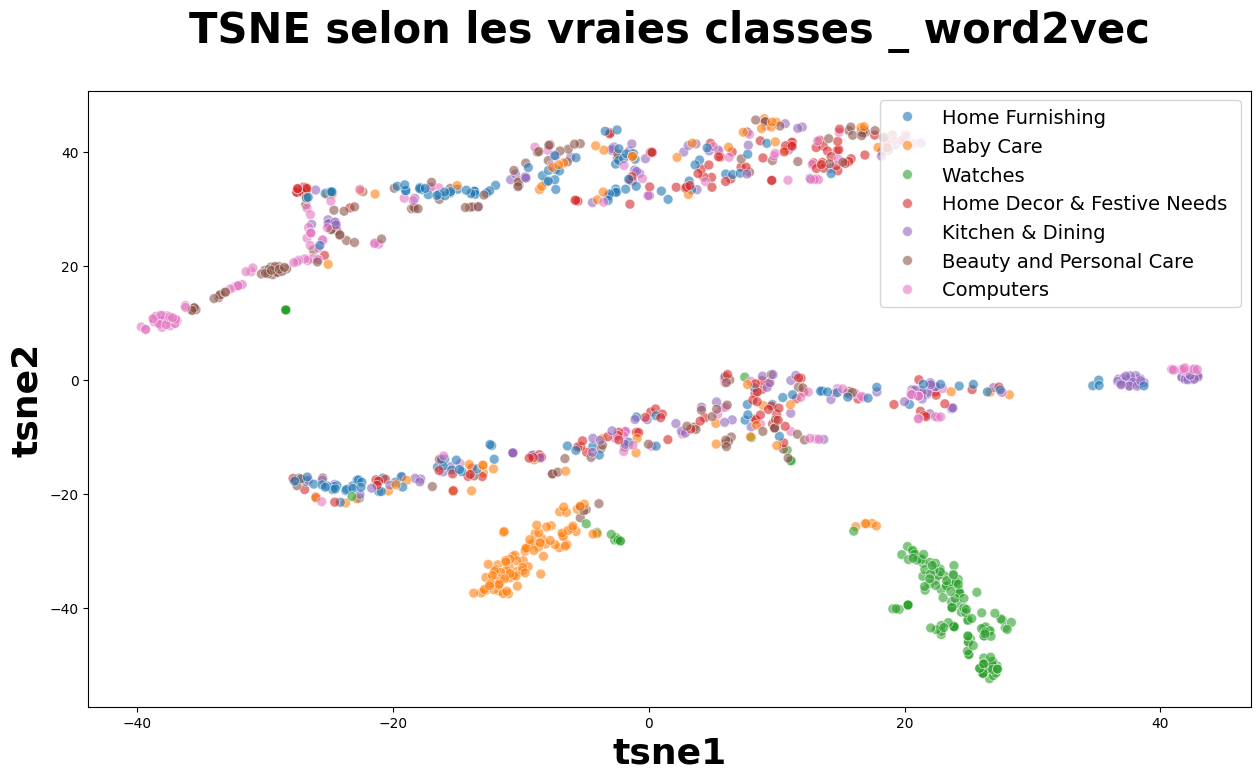

In [25]:
# création dataframe pour affichage avec coordonnées tsne
df_tsne_w2v = pd.DataFrame(X_tsne_w2v, columns=['tsne1', 'tsne2'])
# ajout colonne pour etiquette
df_tsne_w2v["class"] = data_text["label"]

# configuration figure
plt.figure(figsize=(15,8))

# création graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2",# définition des colonnes à utiliser pour les axes
    hue="class", # coloriage des points selon class
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6, # palette avec 4 couleurs, points de taille 50, 0.6 de transparence
    data=df_tsne_w2v, # source des données
    legend="brief") # légende succinte

# titres et labels
plt.title('TSNE selon les vraies classes _ word2vec', fontsize = 30, pad = 35, fontweight = 'bold') # titre du graphique, paramètres de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # label axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # label axe y
plt.legend(prop={'size': 14}) # style légende

# affichage graphique
plt.show()


#### affichage BERT

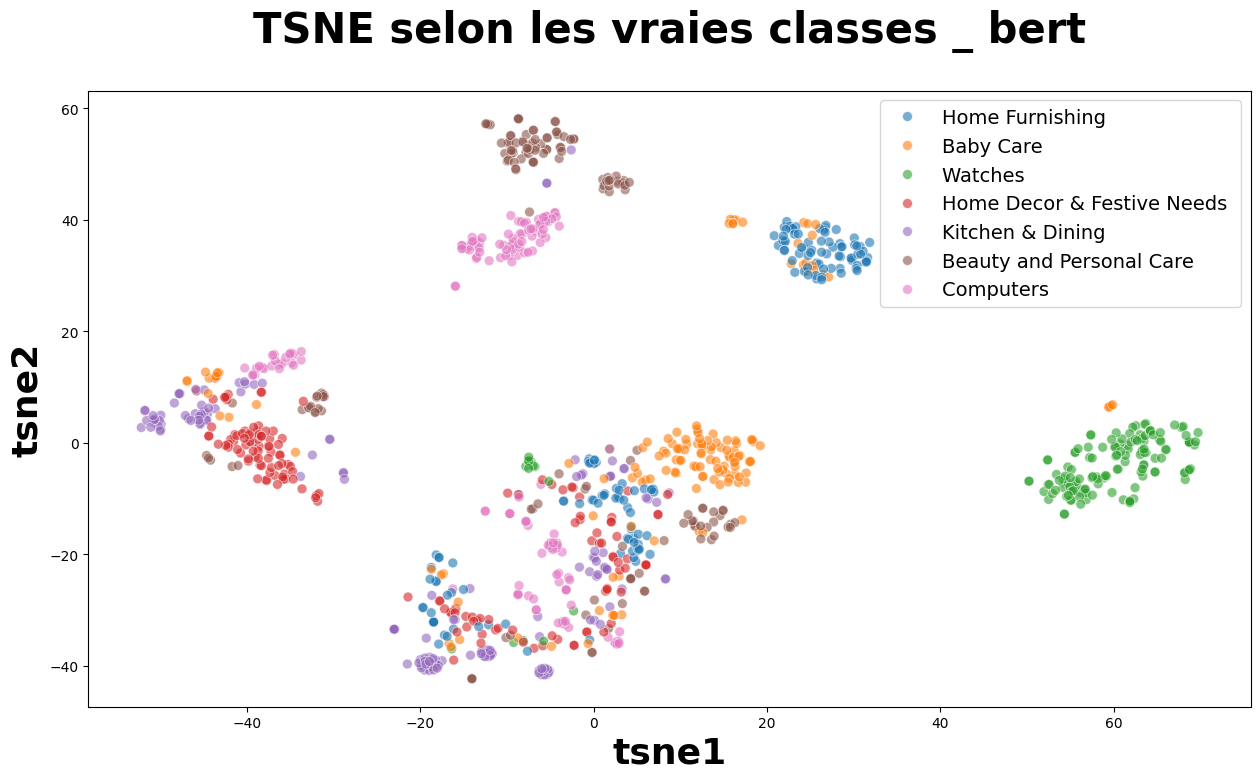

In [26]:
# création dataframe pour affichage avec coordonnées tsne
df_tsne_bert = pd.DataFrame(X_tsne_bert, columns=['tsne1', 'tsne2'])
# ajout colonne pour etiquette
df_tsne_bert["class"] = data_text["label"]

# configuration figure
plt.figure(figsize=(15,8))

# création graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2",# définition des colonnes à utiliser pour les axes
    hue="class", # coloriage des points selon class
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6, # palette avec 4 couleurs, points de taille 50, 0.6 de transparence
    data=df_tsne_bert, # source des données
    legend="brief") # légende succinte

# titres et labels
plt.title('TSNE selon les vraies classes _ bert', fontsize = 30, pad = 35, fontweight = 'bold') # titre du graphique, paramètres de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # label axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # label axe y
plt.legend(prop={'size': 14}) # style légende

# affichage graphique
plt.show()


#### affichage USE

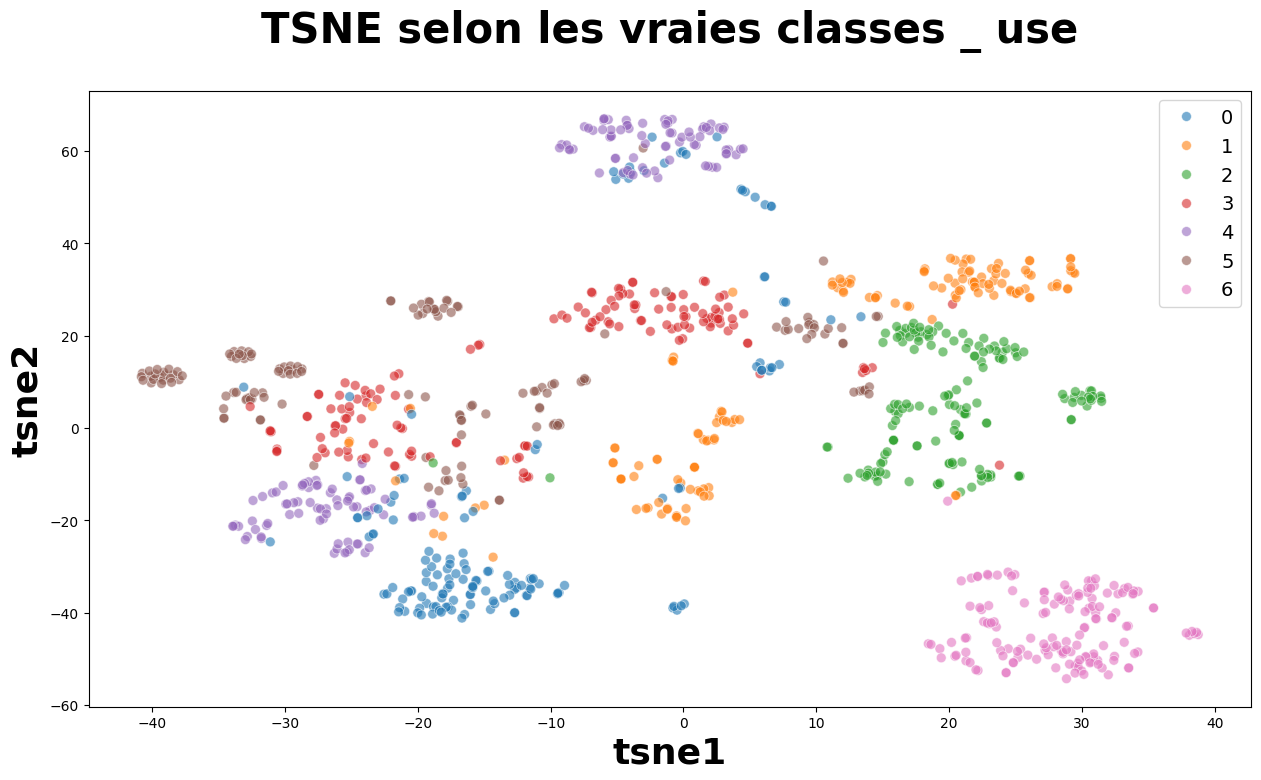

In [27]:
# création dataframe pour affichage avec coordonnées tsne
df_tsne_use = pd.DataFrame(X_tsne_use, columns=['tsne1', 'tsne2'])
# ajout colonne pour etiquette
df_tsne_use["class"] = data_text["label_encoded"]

# configuration figure
plt.figure(figsize=(15,8))

# création graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2",# définition des colonnes à utiliser pour les axes
    hue="class", # coloriage des points selon class
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6, # palette avec 4 couleurs, points de taille 50, 0.6 de transparence
    data=df_tsne_use, # source des données
    legend="brief") # légende succinte

# titres et labels
plt.title('TSNE selon les vraies classes _ use', fontsize = 30, pad = 35, fontweight = 'bold') # titre du graphique, paramètres de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # label axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # label axe y
plt.legend(prop={'size': 14}) # style légende

# affichage graphique
plt.show()


### Création de clusters à partir du T-SNE et affichage des items selon clusters


In [28]:
# import module clustering et métriques
from sklearn import cluster, metrics

# config module cls (4 clusters, et 100 fois avec centroides initiaux diff, recherche celui avec meilleure inertie)
cls_w2v = cluster.KMeans(n_clusters=7, n_init=100)
cls_bert = cluster.KMeans(n_clusters=7, n_init=100)
cls_use = cluster.KMeans(n_clusters=7, n_init=100)
# application kmeans aux données tSNE
cls_w2v.fit(X_tsne_w2v)
cls_bert.fit(X_tsne_bert)
cls_use.fit(X_tsne_use)

KMeans(n_clusters=7, n_init=100)

#### affichage W2V

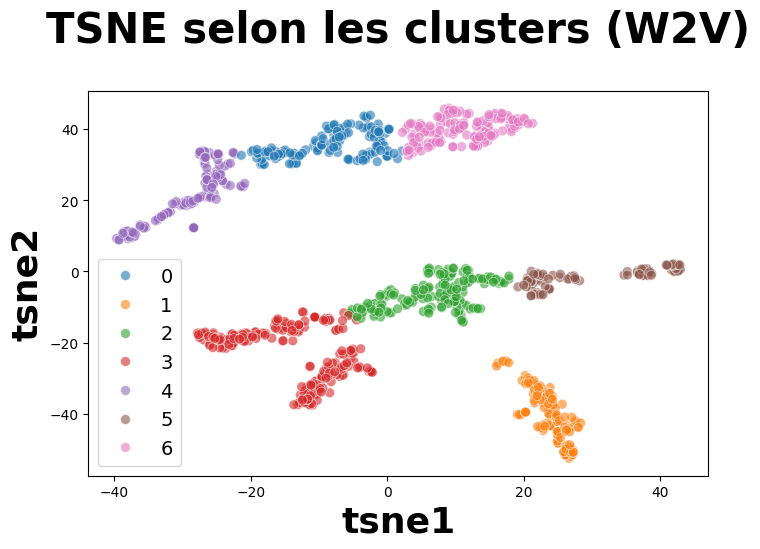

ARI (W2V) :  0.21383580024805154


In [29]:
#Visualisation des clusters
df_tsne_w2v["cluster"] = cls_w2v.labels_ # ajout etiquettes

# config figure
plt.figure(figsize=(8,5))
# création graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2", # selection des données pour axes x et y
    hue="cluster", # coloriage des points en fonction cluter
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6, # palette 7 couleurs, , points taille 50, transparence 0.6
    data=df_tsne_w2v, # source des données pour graph
    legend="brief") # légende succinte

# titres et labels
plt.title('TSNE selon les clusters (W2V)', fontsize = 30, pad = 35, fontweight = 'bold') # titre, paramètre de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # axe y
plt.legend(prop={'size': 14})  # style légende

# affichage graphique
plt.show()

# évaluation clustering
labels = data_text["label"]
print("ARI (W2V) : ", metrics.adjusted_rand_score(labels, cls_w2v.labels_))

#### affichage BERT

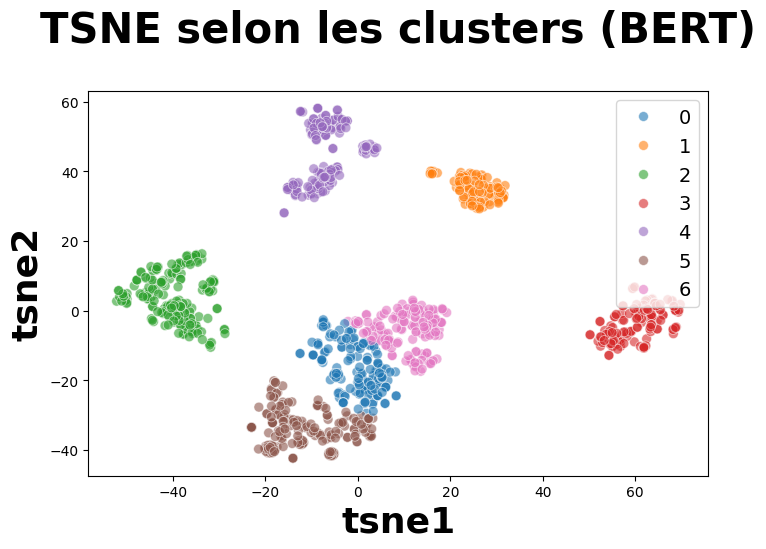

ARI (BERT) :  0.30364225119966826


In [30]:
#Visualisation des clusters
df_tsne_bert["cluster"] = cls_bert.labels_ # ajout etiquettes

# config figure
plt.figure(figsize=(8,5))
# création graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2", # selection des données pour axes x et y
    hue="cluster", # coloriage des points en fonction cluter
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6, # palette 7 couleurs, , points taille 50, transparence 0.6
    data=df_tsne_bert, # source des données pour graph
    legend="brief") # légende succinte

# titres et labels
plt.title('TSNE selon les clusters (BERT)', fontsize = 30, pad = 35, fontweight = 'bold') # titre, paramètre de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # axe y
plt.legend(prop={'size': 14})  # style légende

# affichage graphique
plt.show()

# évaluation clustering
labels = data_text["label"]
print("ARI (BERT) : ", metrics.adjusted_rand_score(labels, cls_bert.labels_))

#### affichage USE

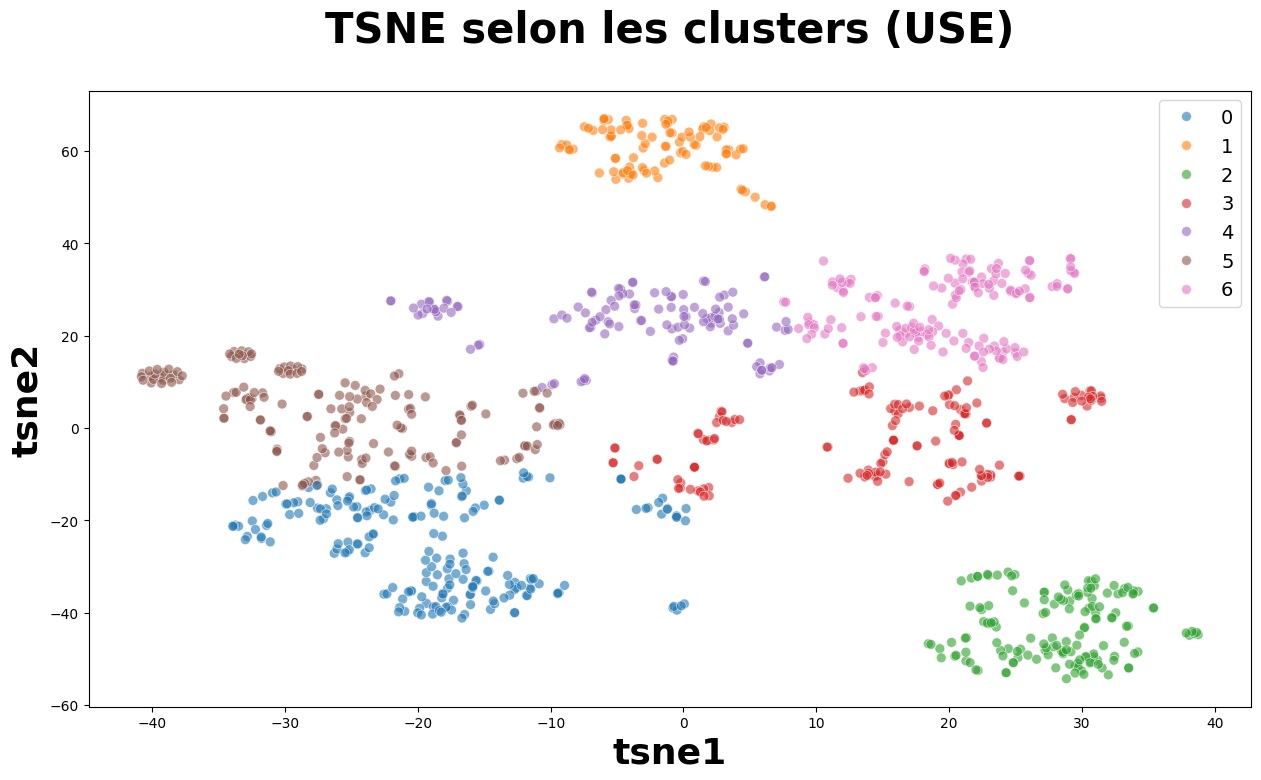

ARI (USE) :  0.4310219015268515


In [31]:
#Visualisation des clusters
df_tsne_use["cluster"] = cls_use.labels_ # ajout etiquettes

# config figure
plt.figure(figsize=(15,8))
# création graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2", # selection des données pour axes x et y
    hue="cluster", # coloriage des points en fonction cluter
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6, # palette 7 couleurs, , points taille 50, transparence 0.6
    data=df_tsne_use, # source des données pour graph
    legend="brief") # légende succinte

# titres et labels
plt.title('TSNE selon les clusters (USE)', fontsize = 30, pad = 35, fontweight = 'bold') # titre, paramètre de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # axe y
plt.legend(prop={'size': 14})  # style légende

# affichage graphique
plt.show()

# évaluation clustering
labels = data_text["label"]
print("ARI (USE) : ", metrics.adjusted_rand_score(labels, cls_use.labels_))

### Analyse par classes

#### w2v

In [32]:
# mAtrice de confusion
conf_mat_w2v = metrics.confusion_matrix(data_text['label_encoded'], cls_w2v.labels_) # calcul la matrice de confusion
print(conf_mat_w2v)# affichage matrice de confusion

[[ 13   5  11  97   6   3  15]
 [ 32   0  34  15  43   0  26]
 [ 12   0  29   3  62  24  20]
 [ 12   0  44  20  12  10  52]
 [ 55   0  21  44   7  11  12]
 [ 24   0  26  21  10  52  17]
 [  0 129   5  10   6   0   0]]


In [33]:
# transformation de la matrice de confusion
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred) # calcul de la matrice de confusion
    
    corresp = np.argmax(conf_mat, axis=0) # trouve la correspondance des clusters
    print ("Correspondance des clusters : ", corresp)# affiche la correspondance
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame() # création d'un dataframe avec etiquettes reelles
    labels['y_pred'] = y_pred # ajoute etiquettes predites
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) # transforme etiquettes predites avec correspondance trouvée
    
    return labels['y_pred_transform'] # renvoie les etiquettes transformées

In [34]:
# application de la transformation et evaluation
cls_w2v_labels_transform = conf_mat_transform(data_text['label_encoded'], cls_w2v.labels_) # applique la fonction de transformation aux etiquettes des clusters
conf_mat_w2v = metrics.confusion_matrix(data_text['label_encoded'], cls_w2v_labels_transform) # calcule la nouvelle matrice de confustion avec les etiquettes transformées
print(conf_mat_w2v) # affiche la matrice de confusion
print()
print(metrics.classification_report(data_text['label_encoded'], cls_w2v_labels_transform)) # affiche rapport de classification détaillé (avec précision, rappel et score F1 pour chaque classe)

Correspondance des clusters :  [4 6 3 0 2 5 3]
[[ 97   0   6  26  13   3   5]
 [ 15   0  43  60  32   0   0]
 [  3   0  62  49  12  24   0]
 [ 20   0  12  96  12  10   0]
 [ 44   0   7  33  55  11   0]
 [ 21   0  10  43  24  52   0]
 [ 10   0   6   5   0   0 129]]

              precision    recall  f1-score   support

           0       0.46      0.65      0.54       150
           1       0.00      0.00      0.00       150
           2       0.42      0.41      0.42       150
           3       0.31      0.64      0.42       150
           4       0.37      0.37      0.37       150
           5       0.52      0.35      0.42       150
           6       0.96      0.86      0.91       150

    accuracy                           0.47      1050
   macro avg       0.44      0.47      0.44      1050
weighted avg       0.44      0.47      0.44      1050



/home/alexandre/anaconda3/envs/stabadenvP6/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/anaconda3/envs/stabadenvP6/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/anaconda3/envs/stabadenvP6/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

<Axes: >

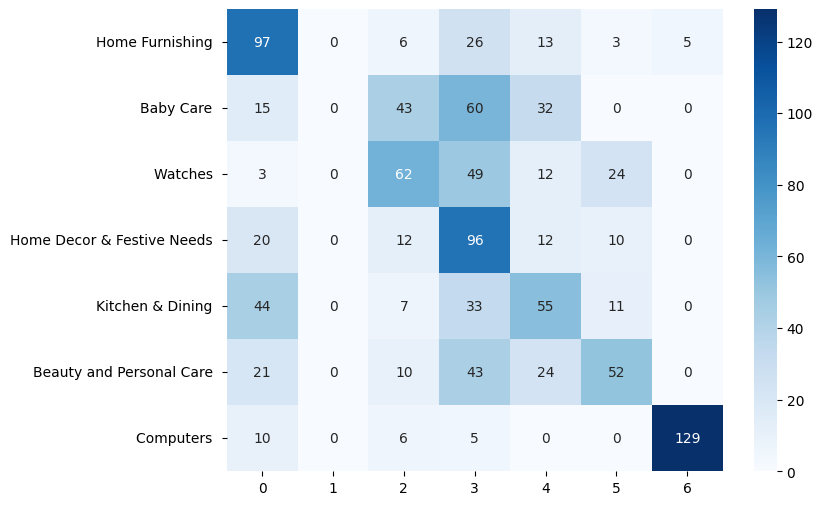

In [35]:
list_labels = ['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers ']

df_cm = pd.DataFrame(conf_mat_w2v, index = [label for label in list_labels],
                  columns = [i for i in "0123456"]) # création dataframe a partir matrice conf avec labels en index et les colonnes
plt.figure(figsize = (8,6)) # configuration de la taille de la figure
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d') # créé une jolie heatmap

#### bert

In [36]:
# mAtrice de confusion
conf_mat_bert = metrics.confusion_matrix(data_text['label_encoded'], cls_bert.labels_) # calcul la matrice de confusion
print(conf_mat_bert)# affichage matrice de confusion

[[  6  20  14   5   0  15  90]
 [ 16   0  21   0  80   9  24]
 [ 32   0  24   0  70  24   0]
 [ 32   0  81   0   0  33   4]
 [ 32  74   0   0   0  27  17]
 [ 22   0  52   0   3  61  12]
 [ 10   0   0 135   0   5   0]]


In [37]:
# application de la transformation et evaluation
cls_bert_labels_transform = conf_mat_transform(data_text['label_encoded'], cls_bert.labels_) # applique la fonction de transformation aux etiquettes des clusters
conf_mat_bert = metrics.confusion_matrix(data_text['label_encoded'], cls_bert_labels_transform) # calcule la nouvelle matrice de confustion avec les etiquettes transformées
print(conf_mat_bert) # affiche la matrice de confusion
print()
print(metrics.classification_report(data_text['label_encoded'], cls_bert_labels_transform)) # affiche rapport de classification détaillé (avec précision, rappel et score F1 pour chaque classe)

Correspondance des clusters :  [2 4 3 6 1 5 0]
[[ 90   0   6  14  20  15   5]
 [ 24  80  16  21   0   9   0]
 [  0  70  32  24   0  24   0]
 [  4   0  32  81   0  33   0]
 [ 17   0  32   0  74  27   0]
 [ 12   3  22  52   0  61   0]
 [  0   0  10   0   0   5 135]]

              precision    recall  f1-score   support

           0       0.61      0.60      0.61       150
           1       0.52      0.53      0.53       150
           2       0.21      0.21      0.21       150
           3       0.42      0.54      0.47       150
           4       0.79      0.49      0.61       150
           5       0.35      0.41      0.38       150
           6       0.96      0.90      0.93       150

    accuracy                           0.53      1050
   macro avg       0.55      0.53      0.53      1050
weighted avg       0.55      0.53      0.53      1050



<Axes: >

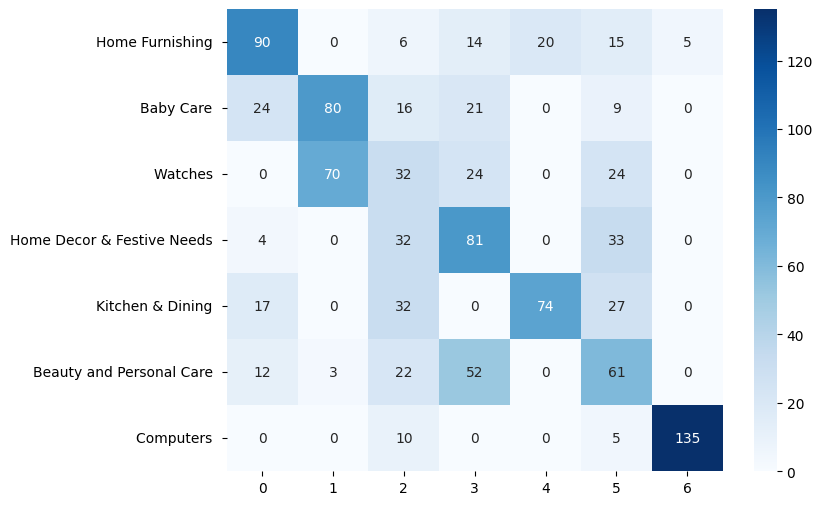

In [38]:
list_labels = ['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers ']

df_cm = pd.DataFrame(conf_mat_bert, index = [label for label in list_labels],
                  columns = [i for i in "0123456"]) # création dataframe a partir matrice conf avec labels en index et les colonnes
plt.figure(figsize = (8,6)) # configuration de la taille de la figure
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d') # créé une jolie heatmap

#### use

In [39]:
# mAtrice de confusion
conf_mat_use = metrics.confusion_matrix(data_text['label_encoded'], cls_use.labels_) # calcul la matrice de confusion
print(conf_mat_use)# affichage matrice de confusion

[[108  20   0   2  10   6   4]
 [ 22   0   0  38   5   5  80]
 [  1   0   0  97   0   1  51]
 [  4   0   0   2  75  64   5]
 [ 66  74   0   0   0  10   0]
 [  8   1   0   6  32  87  16]
 [  0   0 149   1   0   0   0]]


In [40]:
# application de la transformation et evaluation
cls_use_labels_transform = conf_mat_transform(data_text['label_encoded'], cls_use.labels_) # applique la fonction de transformation aux etiquettes des clusters
conf_mat_use = metrics.confusion_matrix(data_text['label_encoded'], cls_use_labels_transform) # calcule la nouvelle matrice de confustion avec les etiquettes transformées
print(conf_mat_use) # affiche la matrice de confusion
print()
print(metrics.classification_report(data_text['label_encoded'], cls_use_labels_transform)) # affiche rapport de classification détaillé (avec précision, rappel et score F1 pour chaque classe)

Correspondance des clusters :  [0 4 6 2 3 5 1]
[[108   4   2  10  20   6   0]
 [ 22  80  38   5   0   5   0]
 [  1  51  97   0   0   1   0]
 [  4   5   2  75   0  64   0]
 [ 66   0   0   0  74  10   0]
 [  8  16   6  32   1  87   0]
 [  0   0   1   0   0   0 149]]

              precision    recall  f1-score   support

           0       0.52      0.72      0.60       150
           1       0.51      0.53      0.52       150
           2       0.66      0.65      0.66       150
           3       0.61      0.50      0.55       150
           4       0.78      0.49      0.60       150
           5       0.50      0.58      0.54       150
           6       1.00      0.99      1.00       150

    accuracy                           0.64      1050
   macro avg       0.66      0.64      0.64      1050
weighted avg       0.66      0.64      0.64      1050



<Axes: >

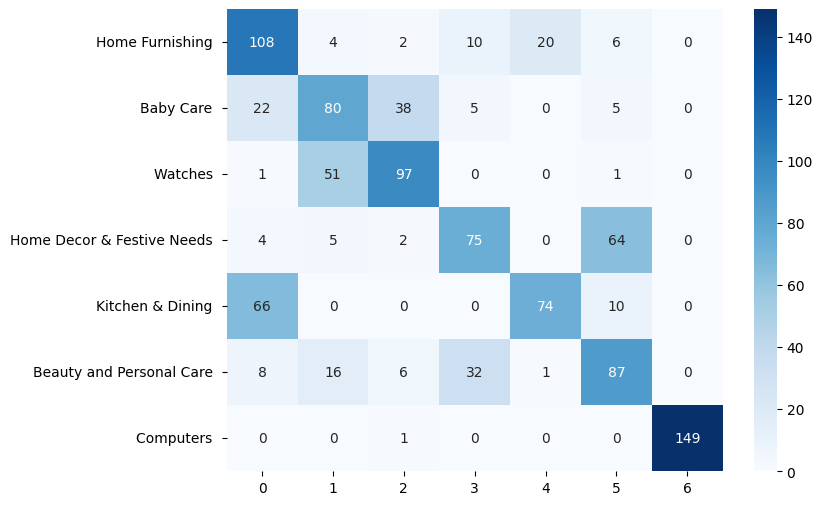

In [41]:
list_labels = ['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers ']

df_cm = pd.DataFrame(conf_mat_use, index = [label for label in list_labels],
                  columns = [i for i in "0123456"]) # création dataframe a partir matrice conf avec labels en index et les colonnes
plt.figure(figsize = (8,6)) # configuration de la taille de la figure
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d') # créé une jolie heatmap